## Investigating the Impact of Residual Connection to Convolutional Layer on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of residual connection with convolutional layers on the performance of EEG classification models. We investigate the relationship between the number of convolutional layers and the resulting accuracy.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %mkdir /content/drive/MyDrive/ED_Experiments
# %mkdir /content/drive/MyDrive/ED_Experiments/ED_CNN_E13

In [ ]:
%mkdir /content/drive/MyDrive/ED_Experiments/SeizureVsEyeOpenEpileptogenicHippocampus


mkdir: cannot create directory ‘/content/drive/MyDrive/ED_Experiments/SeizureVsEyeOpenEpileptogenicHippocampus’: File exists


In [ ]:
%cd /content/drive/MyDrive/ED_Experiments/SeizureVsEyeOpenEpileptogenicHippocampus
%ls

/content/drive/MyDrive/ED_Experiments/SeizureVsEyeOpenEpileptogenicHippocampus
model_fold_1.h5                    model_fold_3_loss_accuracy.png
model_fold_1.log                   model_fold_3_precision_recall.png
model_fold_1_loss_accuracy.png     model_fold_4.h5
model_fold_1_precision_recall.png  model_fold_4.log
model_fold_2.h5                    model_fold_4_loss_accuracy.png
model_fold_2.log                   model_fold_4_precision_recall.png
model_fold_2_loss_accuracy.png     model_fold_5.h5
model_fold_2_precision_recall.png  model_fold_5.log
model_fold_3.h5                    model_fold_5_loss_accuracy.png
model_fold_3.log                   model_fold_5_precision_recall.png


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'm-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_5[i, :], 'b-', label='df_5')
        plt.legend()
        plt.title(f'Eye open + Epileptogenic + Hippocampus vs Seizure data visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

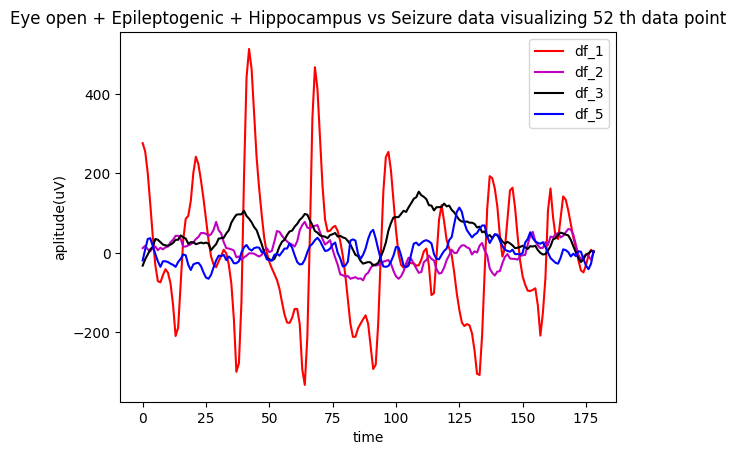

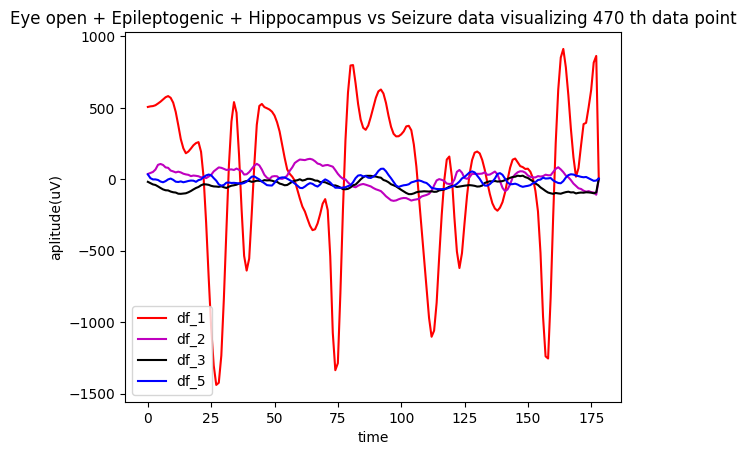

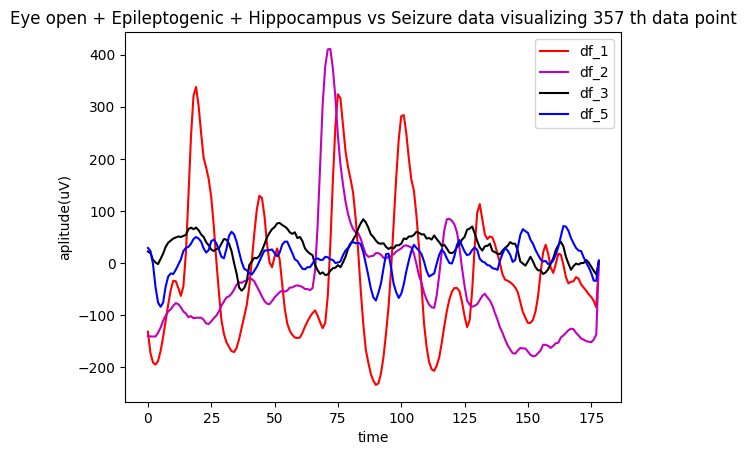

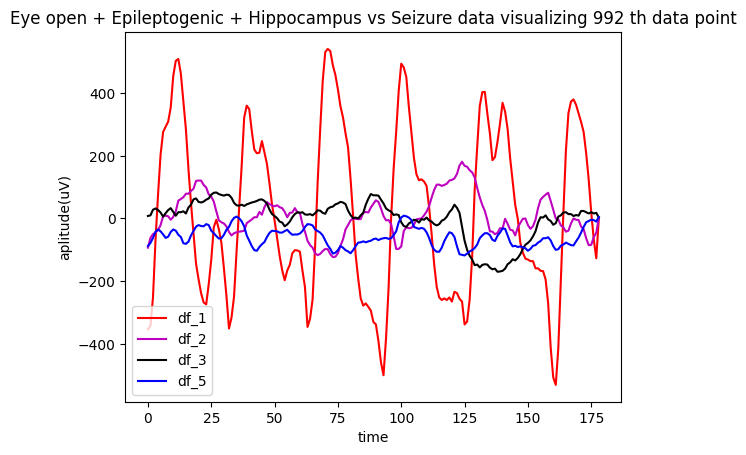

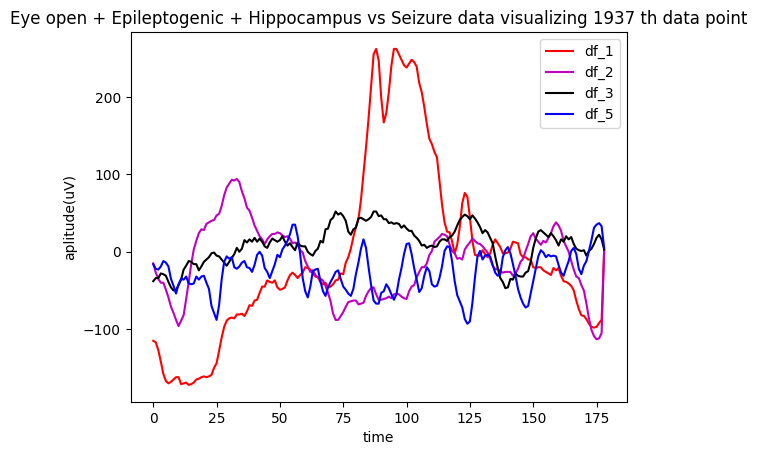

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
data = np.concatenate((df_1, df_2, df_3, df_5))

## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '_loss_accuracy.png')

    plt.show()

In [ ]:
def plot_precision_recall(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['precision'], 'b-')
    ax[0].plot(history.history['val_precision'], 'r-')
    ax[0].legend(['train_precision', 'val_precision'])
    ax[0].set_title('precision curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Precision %')

    ax[1].plot(history.history['recall'], 'b-')
    ax[1].plot(history.history['val_recall'], 'r-')
    ax[1].legend(['train_recall', 'val_recall'])
    ax[1].set_title('recall curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Recall %')

    plt.suptitle(title)
    plt.savefig(title + '_precision_recall.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):
    data[:, -1] = np.where(data[:, -1] != 1, 0, data[:, -1])

    X = data[:, :-1]
    y = data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
X.shape

(9200, 178)

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the Residual Connection



In [ ]:


def residual_block(x, filters, kernel_size, padding='same', activation='relu'):
    shortcut = x
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation(activation)(x)
    return x

def create_residual_eeg_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=128, kernel_size=5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=128, kernel_size=5)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=1024, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.Conv1D(filters=2048, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = residual_block(x, filters=2048, kernel_size=3)
    x = layers.MaxPooling1D(2, padding='same')(x)

    x = layers.GlobalAveragePooling1D()(x)  # Replace Flatten layer with GlobalAveragePooling1D
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



X_train:  (7360, 178, 1)
X_val:  (1840, 178, 1)
y_train:  (7360,)
y_val:  (1840,)


---- fold = 1 ------

Epoch 1/100
230/230 [==============================] - 49s 94ms/step - loss: 0.1328 - accuracy: 0.9563 - precision: 0.9245 - recall: 0.8984 - val_loss: 0.0981 - val_accuracy: 0.9625 - val_precision: 0.8841 - val_recall: 0.9783
Epoch 2/100
230/230 [==============================] - 24s 105ms/step - loss: 0.1153 - accuracy: 0.9615 - precision: 0.9303 - recall: 0.9147 - val_loss: 0.0555 - val_accuracy: 0.9799 - val_precision: 0.9732 - val_recall: 0.9457
Epoch 3/100
230/230 [==============================] - 25s 111ms/step - loss: 0.0870 - accuracy: 0.9694 - precision: 0.9434 - recall: 0.9337 - val_loss: 0.0475 - val_accuracy: 0.9832 - val_precision: 0.9633 - val_recall: 0.9696
Epoch 4/100
230/230 [==============================] - 26s 112ms/step - loss: 0.0766 - accuracy: 0.9734 - precision: 0.9448 - recall: 0.9489 - val_loss: 0.0424 - val_accuracy: 0.9837 - val_precision: 0.9778 - va

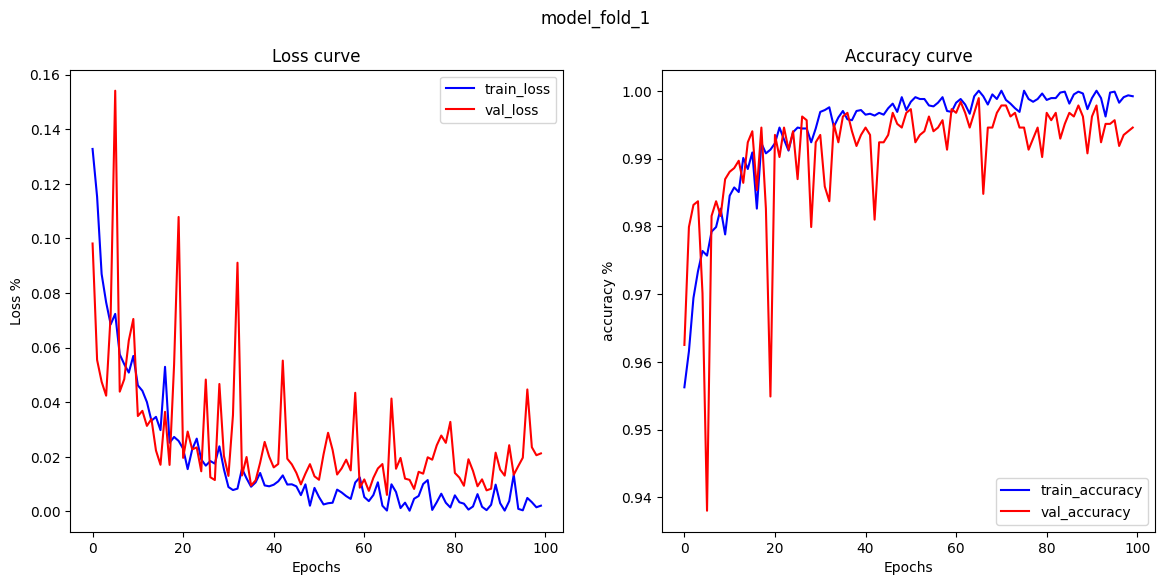

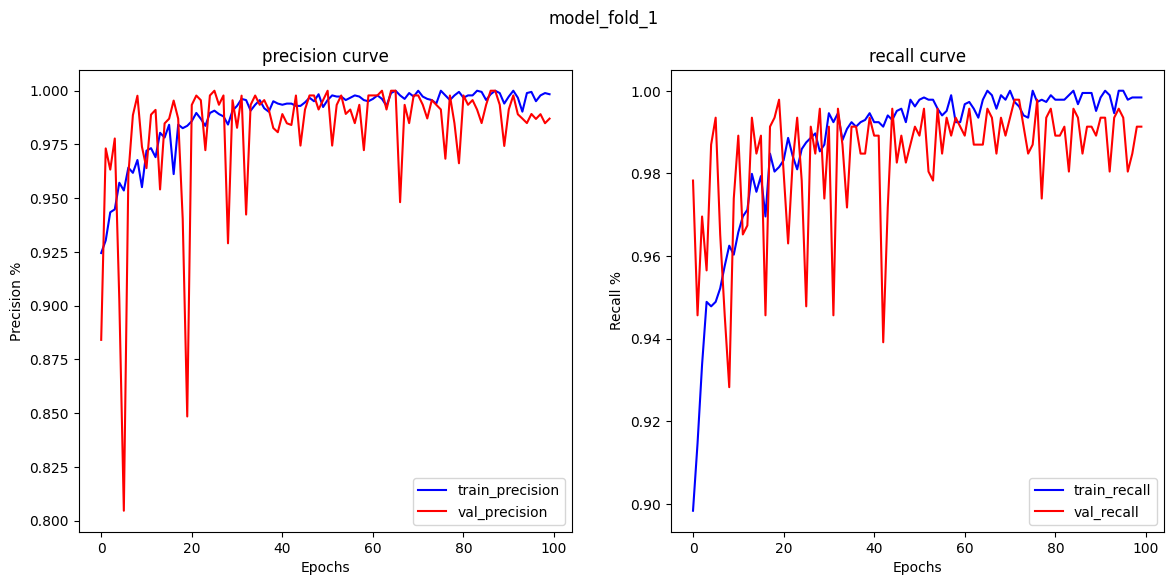

X_train:  (7360, 178, 1)
X_val:  (1840, 178, 1)
y_train:  (7360,)
y_val:  (1840,)


---- fold = 2 ------

Epoch 1/100
230/230 [==============================] - 36s 96ms/step - loss: 0.1237 - accuracy: 0.9499 - precision: 0.8995 - recall: 0.9000 - val_loss: 0.1102 - val_accuracy: 0.9685 - val_precision: 0.9809 - val_recall: 0.8913
Epoch 2/100
230/230 [==============================] - 22s 95ms/step - loss: 0.0986 - accuracy: 0.9641 - precision: 0.9325 - recall: 0.9234 - val_loss: 0.0636 - val_accuracy: 0.9772 - val_precision: 0.9750 - val_recall: 0.9326
Epoch 3/100
230/230 [==============================] - 24s 105ms/step - loss: 0.0946 - accuracy: 0.9651 - precision: 0.9309 - recall: 0.9293 - val_loss: 0.0608 - val_accuracy: 0.9804 - val_precision: 0.9589 - val_recall: 0.9630
Epoch 4/100
230/230 [==============================] - 18s 80ms/step - loss: 0.0978 - accuracy: 0.9674 - precision: 0.9372 - recall: 0.9321 - val_loss: 0.0673 - val_accuracy: 0.9717 - val_precision: 0.9700 - val_

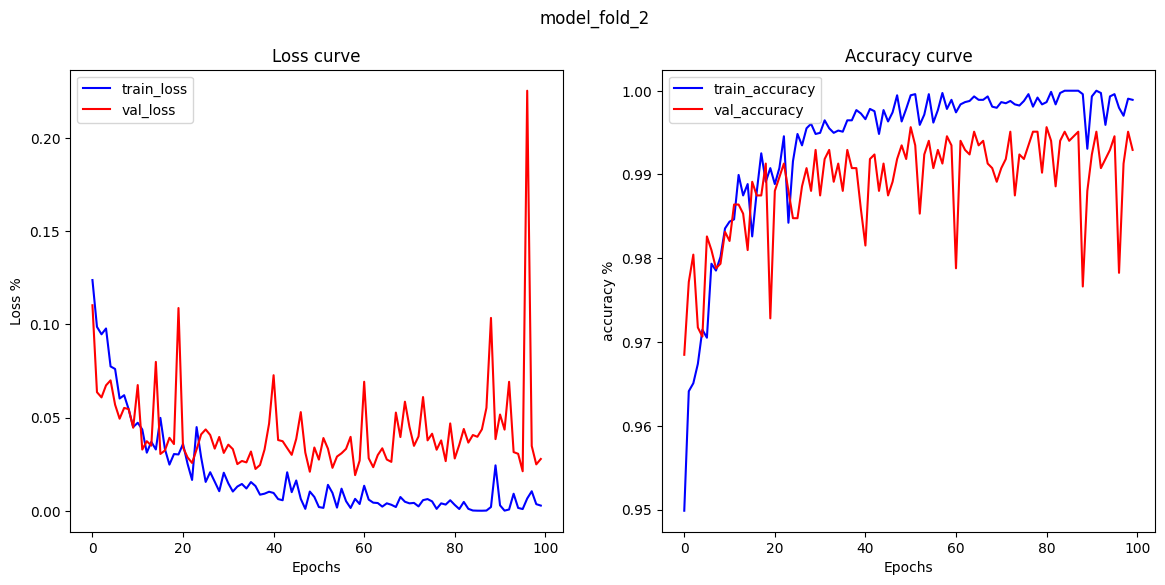

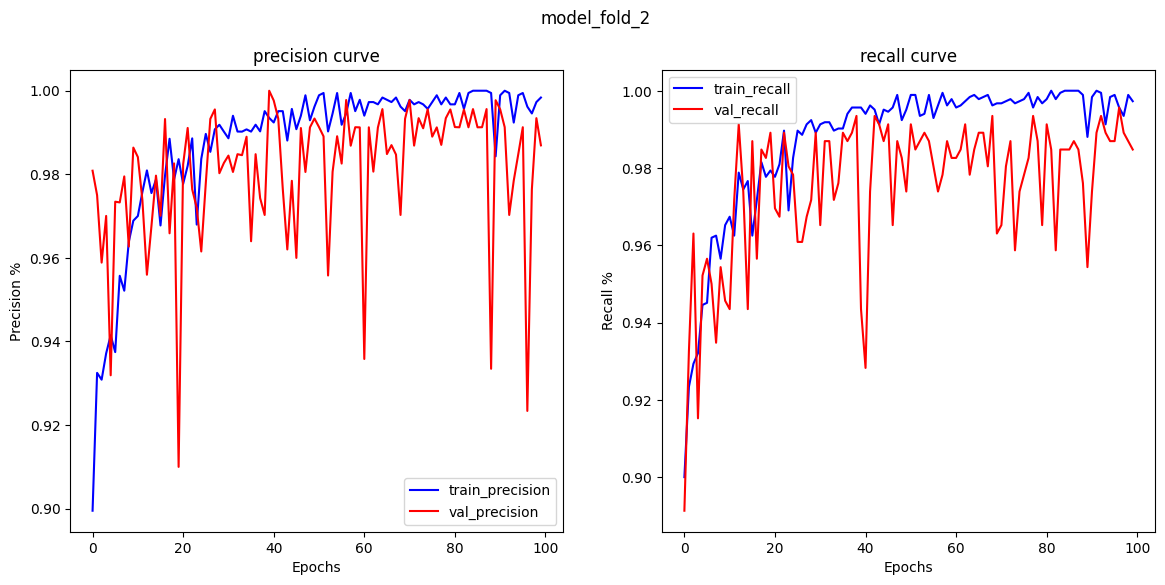

X_train:  (7360, 178, 1)
X_val:  (1840, 178, 1)
y_train:  (7360,)
y_val:  (1840,)


---- fold = 3 ------

Epoch 1/100
230/230 [==============================] - 36s 93ms/step - loss: 0.1230 - accuracy: 0.9580 - precision: 0.9293 - recall: 0.9005 - val_loss: 0.0874 - val_accuracy: 0.9766 - val_precision: 0.9264 - val_recall: 0.9848
Epoch 2/100
230/230 [==============================] - 25s 109ms/step - loss: 0.0989 - accuracy: 0.9662 - precision: 0.9326 - recall: 0.9321 - val_loss: 0.0633 - val_accuracy: 0.9783 - val_precision: 0.9795 - val_recall: 0.9326
Epoch 3/100
230/230 [==============================] - 25s 108ms/step - loss: 0.0780 - accuracy: 0.9719 - precision: 0.9435 - recall: 0.9440 - val_loss: 0.0485 - val_accuracy: 0.9848 - val_precision: 0.9758 - val_recall: 0.9630
Epoch 4/100
230/230 [==============================] - 19s 81ms/step - loss: 0.0829 - accuracy: 0.9711 - precision: 0.9385 - recall: 0.9462 - val_loss: 0.1990 - val_accuracy: 0.9092 - val_precision: 0.7367 - val

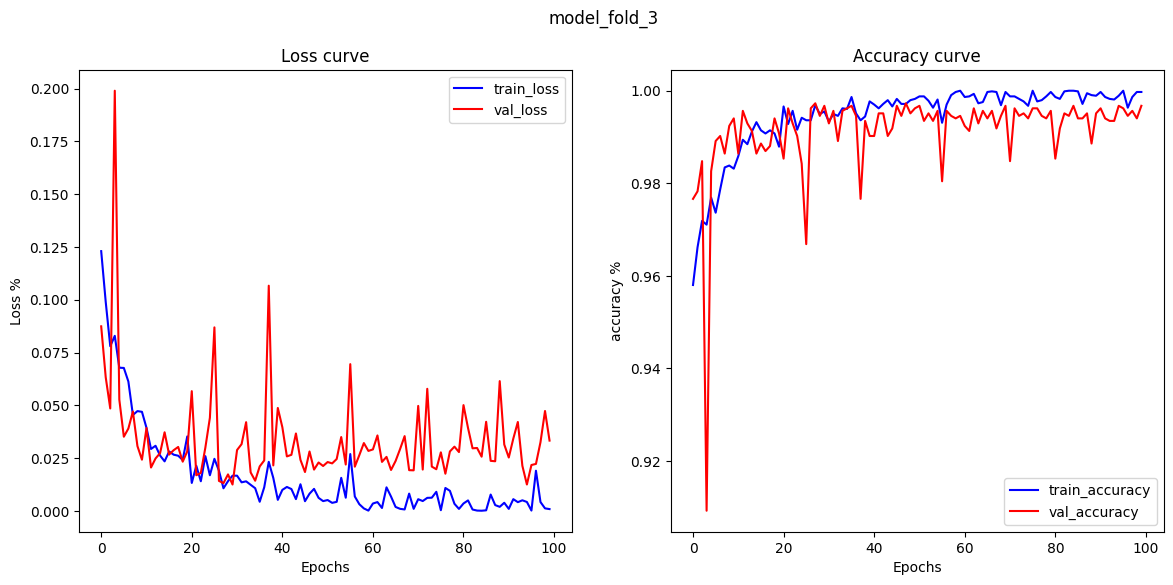

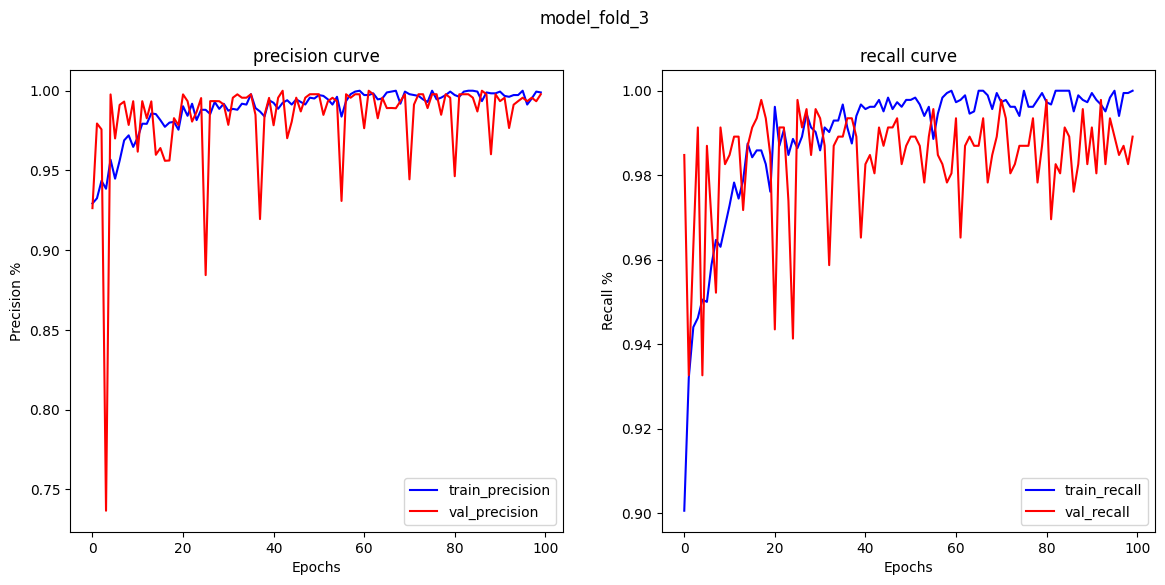

X_train:  (7360, 178, 1)
X_val:  (1840, 178, 1)
y_train:  (7360,)
y_val:  (1840,)


---- fold = 4 ------

Epoch 1/100
230/230 [==============================] - 40s 111ms/step - loss: 0.1169 - accuracy: 0.9522 - precision: 0.9057 - recall: 0.9027 - val_loss: 0.0711 - val_accuracy: 0.9777 - val_precision: 0.9429 - val_recall: 0.9696
Epoch 2/100
230/230 [==============================] - 19s 82ms/step - loss: 0.1004 - accuracy: 0.9630 - precision: 0.9327 - recall: 0.9185 - val_loss: 0.0753 - val_accuracy: 0.9766 - val_precision: 0.9484 - val_recall: 0.9587
Epoch 3/100
230/230 [==============================] - 19s 81ms/step - loss: 0.0797 - accuracy: 0.9705 - precision: 0.9422 - recall: 0.9397 - val_loss: 0.0741 - val_accuracy: 0.9739 - val_precision: 0.9256 - val_recall: 0.9739
Epoch 4/100
230/230 [==============================] - 18s 80ms/step - loss: 0.0694 - accuracy: 0.9773 - precision: 0.9534 - recall: 0.9560 - val_loss: 0.0913 - val_accuracy: 0.9728 - val_precision: 0.9767 - val_

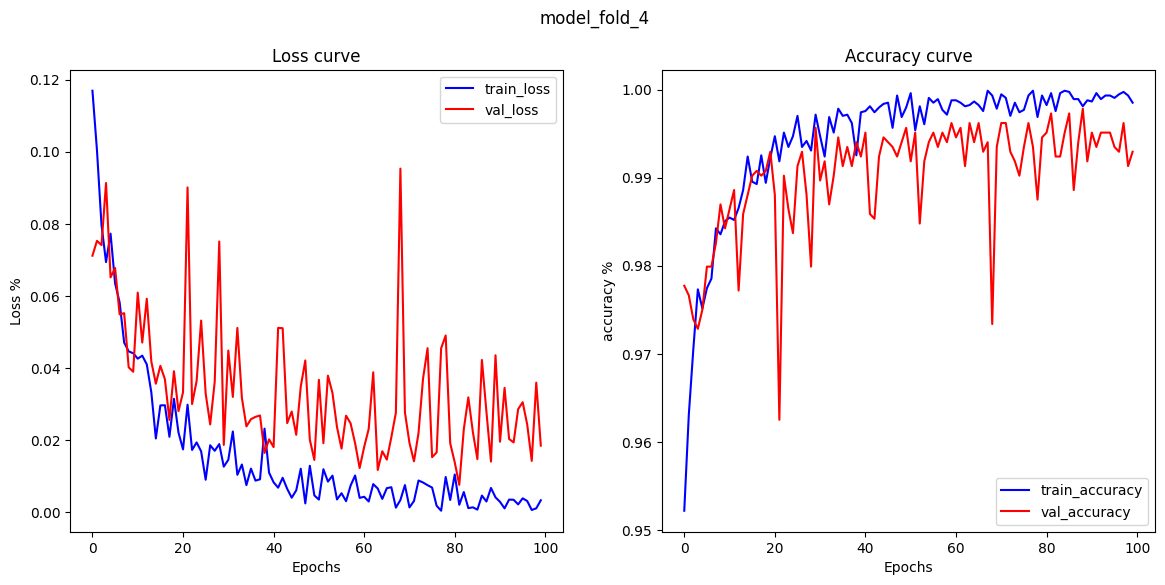

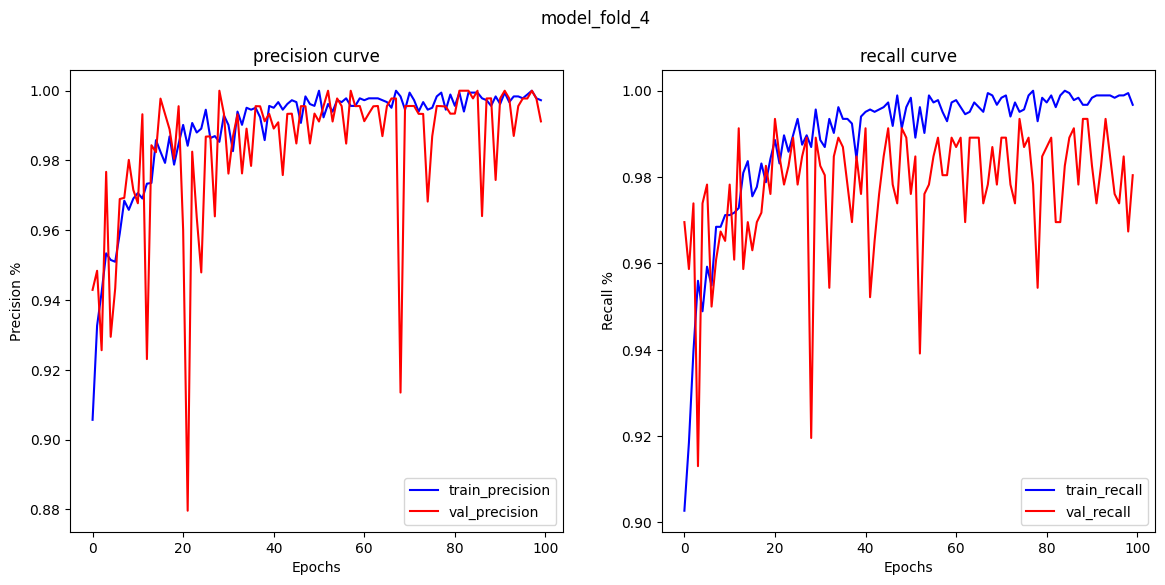

X_train:  (7360, 178, 1)
X_val:  (1840, 178, 1)
y_train:  (7360,)
y_val:  (1840,)


---- fold = 5 ------

Epoch 1/100
230/230 [==============================] - 35s 94ms/step - loss: 0.1145 - accuracy: 0.9582 - precision: 0.9308 - recall: 0.8995 - val_loss: 0.3257 - val_accuracy: 0.9342 - val_precision: 0.7948 - val_recall: 0.9935
Epoch 2/100
230/230 [==============================] - 22s 96ms/step - loss: 0.0983 - accuracy: 0.9671 - precision: 0.9390 - recall: 0.9288 - val_loss: 0.0620 - val_accuracy: 0.9788 - val_precision: 0.9546 - val_recall: 0.9609
Epoch 3/100
230/230 [==============================] - 21s 92ms/step - loss: 0.0791 - accuracy: 0.9746 - precision: 0.9589 - recall: 0.9386 - val_loss: 0.0525 - val_accuracy: 0.9815 - val_precision: 0.9513 - val_recall: 0.9761
Epoch 4/100
230/230 [==============================] - 21s 90ms/step - loss: 0.0767 - accuracy: 0.9758 - precision: 0.9561 - recall: 0.9467 - val_loss: 0.0500 - val_accuracy: 0.9832 - val_precision: 0.9694 - val_r

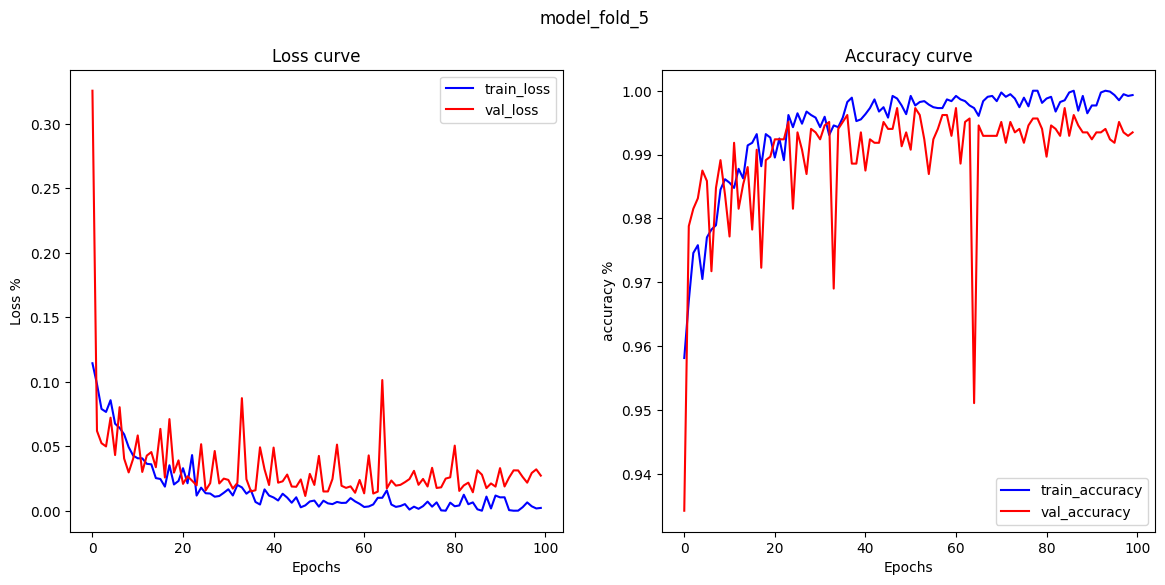

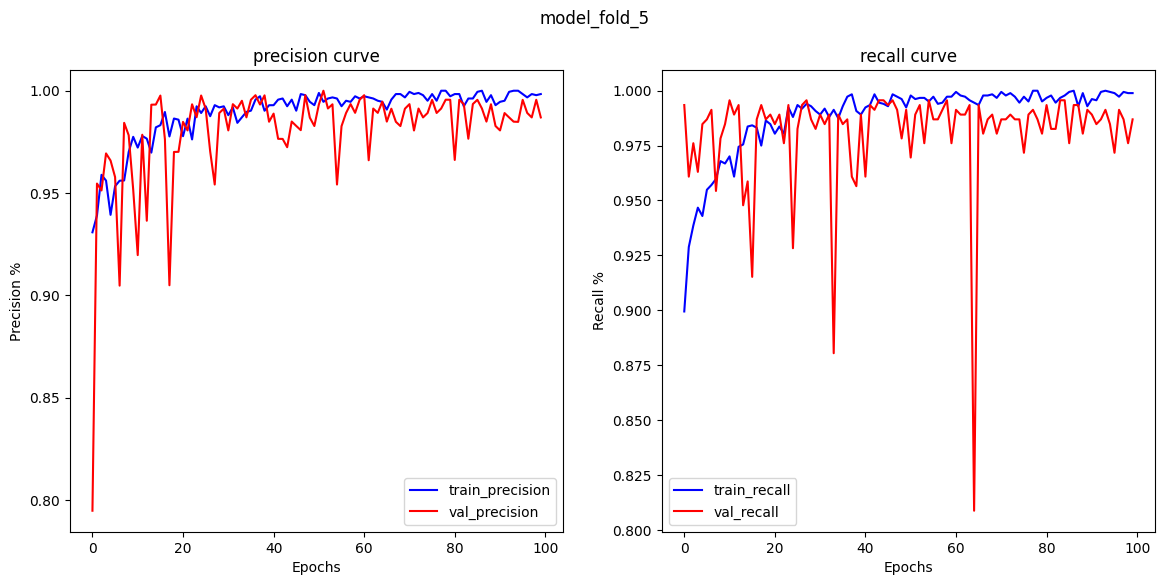

Mean Accuracy: 0.9973913192749023
Mean Precision: 0.9960850358009339
Mean Recall: 0.993478262424469
Mean F1_Score: 0.9947799413843165


In [ ]:

# Perform cross-validation
fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1score = []
fold = 1

for train_index, val_index in skf.split(X, y):
    X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)
    print('X_train: ', X_train.shape)
    print('X_val: ', X_val.shape)
    print('y_train: ', y_train.shape)
    print('y_val: ', y_val.shape)


    # model = eegClassifier(input_shape)
    model = create_residual_eeg_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                         tf.keras.metrics.Precision(name='precision'),
                                                                         tf.keras.metrics.Recall(name='recall')])
    log_file = f"model_fold_{fold}.log"
    model_name = f"model_fold_{fold}.h5"

    # Clear existing log handlers and close log files
    root_logger = logging.getLogger()
    for handler in root_logger.handlers:
        handler.close()
    root_logger.handlers.clear()

    # Create a separate log file for each model
    logger = init_logger(log_file, stdout=False)


    logger.info(f"\n\n---- fold = {fold} -------\n")
    print(f"\n\n---- fold = {fold} ------\n")

    # Define the checkpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

    # Train the model and capture the history
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                        callbacks=[checkpoint])

    # Log loss and accuracy
    for i, (loss, accuracy, precision, recall) in enumerate(zip(history.history['loss'],
                                                                history.history['accuracy'],
                                                                history.history['precision'],
                                                                history.history['recall'])):
        logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall}")

    for i, (val_loss, val_accuracy, val_precision, val_recall) in enumerate(zip(history.history['val_loss'],
                                                                                history.history['val_accuracy'],
                                                                                history.history['val_precision'],
                                                                                history.history['val_recall'])):
        logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


    # Evaluate the model
    best_model_path = model_name
    best_model = tf.keras.models.load_model(best_model_path)
    loss_scale_optimizer, accuracy, precision, recall = best_model.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)
    fold_precision.append(precision)
    fold_recall.append(recall)

    # Log fold accuracy
    logger.info(f"model_Fold = {fold} accuracy: {accuracy}")
    logger.info(f"model_Fold = {fold} precision: {precision}")
    logger.info(f"model_Fold = {fold} recall: {recall}")


    print(f"model_Fold = {fold} accuracy: {accuracy}")
    print(f"model_Fold = {fold} precision: {precision}")
    print(f"model_Fold = {fold} recall: {recall}")
    print(f"model_Fold = {fold} f1_score: {2*(precision*recall) / (precision + recall)}")

    plot_loss_accuracy(history, f"model_fold_{fold}")
    plot_precision_recall(history, f"model_fold_{fold}")
    # plot_accuracy(history)

    fold += 1

# Calculate the average accuracy across all folds
mean_accuracy = np.mean(fold_accuracy)
mean_precision = np.mean(fold_precision)
mean_recall = np.mean(fold_recall)
mean_f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)

print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1_Score:", mean_f1_score)